In [1]:
import torch
from pycocotools.coco import COCO
import numpy as np
import shutil
from tqdm import tqdm
from models import Clipper
import os
import random
import sys
import h5py
from torchvision import transforms
from PIL import Image
import utils
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Sampling random 30k images from val set

In [36]:
import os
import random

def sample_images(directory, num_samples=30000):
    image_files = os.listdir(directory)
    sampled_images = random.choices(image_files, k=num_samples)
    return sampled_images

# # Example usage
directory_path = '/weka/proj-fmri/shared/coco/val2017'
sampled_images = sample_images(directory_path)
# # print(sampled_images[:10])  # Print the first 10 sampled image names

len(sampled_images)

30000

In [2]:
sample_dir = "/weka/proj-fmri/shared/coco/sampled_imgs"
sampled_images = os.listdir(sample_dir)
for i in tqdm(range(len(sampled_images))):
    if len(os.listdir(sample_dir)) == 30000:
        print("already sampled")
        break
    img_path = os.path.join(directory_path, sampled_images[i])
    sam_img_path = os.path.join(sample_dir, f"img{i}.jpg")
    shutil.copy2(img_path, sam_img_path)
    

  0%|                                                                                                                                                            | 0/30000 [00:00<?, ?it/s]

already sampled


In [5]:
#Getting Versatile Diffusion

In [4]:
from diffusers import VersatileDiffusionDualGuidedPipeline, UniPCMultistepScheduler
device = torch.device("cuda")
cache_dir = "/weka/proj-fmri/shared/cache/vd"
try:
    vd_pipe =  VersatileDiffusionDualGuidedPipeline.from_pretrained("/weka/proj-fmri/shared/cache/models--shi-labs--versatile-diffusion/snapshots/2926f8e11ea526b562cd592b099fcf9c2985d0b7/").to(device).to(torch.float16)
except:
    print("Downloading Versatile Diffusion to")
    vd_pipe =  VersatileDiffusionDualGuidedPipeline.from_pretrained(
            "shi-labs/versatile-diffusion", cache_dir=cache_dir).to(device).to(torch.float16)
    
generator = torch.Generator(device="cuda").manual_seed(42)

In [5]:
vd_pipe.image_unet.eval()
vd_pipe.vae.eval()
vd_pipe.image_unet.requires_grad_(False)
vd_pipe.vae.requires_grad_(False)

vd_pipe.scheduler = UniPCMultistepScheduler.from_pretrained("shi-labs/versatile-diffusion", subfolder="scheduler", cache_dir=cache_dir)
num_inference_steps = 20

# Set weighting of Dual-Guidance 
text_image_ratio = .0 # .5 means equally weight text and image, 0 means use only image

In [ ]:
#Saving recon images
from PIL import Image
vd_savedir = "/weka/proj-fmri/shared/coco/vd_imgs"
sam_img = os.listdir(sample_dir)
vd_pipe.set_progress_bar_config(disable=True)
for i in tqdm(range(len(sam_img))):
    if len(os.listdir(vd_savedir)) == 30000:
        print("Sampled images already saved")
        break
    img = Image.open(os.path.join(sample_dir, sam_img[i]))
    vd_img = vd_pipe(image=img, prompt=" ", generator=generator, disable_tqdm=True).images[0]
    vd_img.save(os.path.join(vd_savedir, sam_img[i]))


  0%|                                                                                                                                                            | 0/30000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.66it/s]


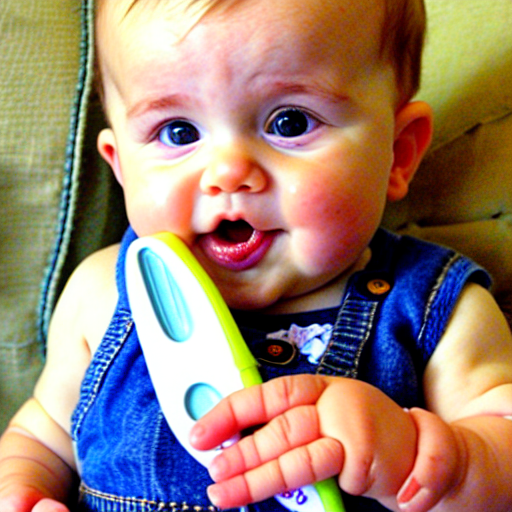

In [9]:
sam_img = os.listdir(sample_dir)
img = Image.open(os.path.join(sample_dir, sam_img[0]))
image = vd_pipe(image=img, prompt="Green aligns on top, very prominent meeting trump", text_to_image_strength=text_image_ratio, generator=generator).images[0]
image

In [4]:
#Loading VITBigG
data_path="/weka/proj-fmri/shared/mindeyev2_dataset"
data_type = torch.float16
device = torch.device("cuda")

In [5]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


In [6]:
#Loading the unclip

In [7]:
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:1]
images = torch.Tensor(images).to("cpu").to(data_type)

In [8]:
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
diffusion_engine.to(device)
diffusion_engine.eval()

ckpt_path = '/weka/proj-fmri/shared/cache/sdxl_unclip/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

image = images[:1].to(device)
batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * image.shape[-1],
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [9]:
unclip_savedir = "/weka/proj-fmri/shared/coco/xlunclip_imgs"
sam_img = os.listdir(sample_dir)
def convert_and_normalize(image_path):
    img = Image.open(image_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img)
    return img_tensor

In [11]:
for i in tqdm(range(len(sam_img))):
    if len(os.listdir(unclip_savedir)) == 30000:
        print("Sampled images already saved")
        break
    img_path = os.path.join(sample_dir, sam_img[i])
    proc_img = convert_and_normalize(img_path)
    clip_img = clip_img_embedder(proc_img.unsqueeze(0).cuda())
    samples = utils.unclip_recon(clip_img,
                             diffusion_engine,
                             vector_suffix)
    img_unclip = transforms.ToPILImage()(samples[0])
    img_unclip.save(os.path.join(unclip_savedir, sam_img[i]))


  0%|                                                                                                                                                            | 0/30000 [00:00<?, ?it/s]/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  2%|██▋                                                                                                                 

ValueError: mean length and number of channels do not match. Got torch.Size([3]) and torch.Size([1, 1, 224, 224]).